<h1><center>Laboratorio 7: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2025</strong></center>

### Cuerpo Docente:

- Profesores: Diego Cortez, Gabriel Iturra
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Nicolás Cabello, Cristopher Urbina

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: María Jesús Valenzuela
- Nombre de alumno 2: Matías Zúñiga


### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/jesuvalenzuela/NanSquad)

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda **fuertemente** asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.


### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import shap
from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import AnchorTabular


In [2]:
df = pd.read_csv('diabetes_data.csv')
df.head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Clasificación de pacientes con diabetes (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

Tareas:
1. En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento, realice los siguientes pasos:
  * Realice una breve exploración de los datos y determine si aplicará transformaciones (MinMaxScaler, StandardScaler, etc.) en alguna/s de las variables. (1 punto)
  * Cree un conjunto de entrenamiento y uno de prueba, con una proporción de 1/3 en el conjunto de prueba. (0.5 puntos)
  * Cree un ColumnTransformer de preprocesamiento donde aplique las transformaciones determinadas anteriormente. Fije el parámetro `verbose_feature_names_out=False` y fije la salida del ColumnTransformer en formato pandas mediante el método `.set_output(transform='pandas')`. (1 punto)
  *  Cree un pipeline donde integre el preprocesamiento y el modelo `XGBoost` y entrene el modelo. Luego utilice `classification_report(..)` para reportar el desempeño del modelo. (1 punto)

Comente sus decisiones y los resultados obtenidos con el modelo.

2. Luego, le pide responder las siguientes preguntas:
  *  ¿Es acaso un buen predictor de diabetes? (0.5 puntos)
  * ¿Qué buscan explicar las métricas utilizadas? (0.5 puntos)
  * ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?(0.5 puntos)

In [3]:
# Mini EDA
print("shape:", df.shape, "\n")
print(df.isna().sum().sum(), "missing total", "\n")
print(df['Diabetes'].value_counts(normalize=True), "\n")      # balance de clases
df.describe().T

shape: (70692, 18) 

0 missing total 

Diabetes
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64 



,count,mean,std,min,25%,50%,75%,max
Age,70692.0,8.584055,2.852153,1.0,7.0,9.0,11.0,13.0
Sex,70692.0,0.456997,0.498151,0.0,0.0,0.0,1.0,1.0
HighChol,70692.0,0.525703,0.499342,0.0,0.0,1.0,1.0,1.0
CholCheck,70692.0,0.975259,0.155336,0.0,1.0,1.0,1.0,1.0
BMI,70692.0,29.856985,7.113954,12.0,25.0,29.0,33.0,98.0
Smoker,70692.0,0.475273,0.499392,0.0,0.0,0.0,1.0,1.0
HeartDiseaseorAttack,70692.0,0.147810,0.354914,0.0,0.0,0.0,0.0,1.0
PhysActivity,70692.0,0.703036,0.456924,0.0,0.0,1.0,1.0,1.0
Fruits,70692.0,0.611795,0.487345,0.0,0.0,1.0,1.0,1.0
Veggies,70692.0,0.788774,0.408181,0.0,1.0,1.0,1.0,1.0


In [4]:
# Verificar si tenemos variables continuas
def get_decimal_places(number):
    s = str(number)
    if '.' in s:
        return float(s.split('.')[-1])
    return 0

for col in df.columns.tolist():
    print(f'{col}: ', df[col].apply(get_decimal_places).sum())


Age:  0.0
Sex:  0.0
HighChol:  0.0
CholCheck:  0.0
BMI:  0.0
Smoker:  0.0
HeartDiseaseorAttack:  0.0
PhysActivity:  0.0
Fruits:  0.0
Veggies:  0.0
HvyAlcoholConsump:  0.0
GenHlth:  0.0
MentHlth:  0.0
PhysHlth:  0.0
DiffWalk:  0.0
Stroke:  0.0
HighBP:  0.0
Diabetes:  0.0


Se observan que todas las variables toman exclusivamente valores enteros. Sin embargo, algunas de ellas, como "Age", "BMI", "MentHlth" y "PhysHlth", en realidad son variables continuas discretizadas. En particular, y considerando que XGB no es muy sensible a las escalas de los datos, se aplicará escalado exclusivamente a "MentHlth" y "PhysHlth" para no perder interpretabilidad en "Age", "BMI", cuyos valores tienen significado reconocible.

In [5]:
# Train-test split
y = df["Diabetes"].astype(int)
X = df.drop(columns=["Diabetes"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=1/3,
    stratify=y,
    random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(47128, 17) (23564, 17) (47128,) (23564,)


In [6]:
# Column Transformer + Salida pandas
continuous_cols = ["MentHlth", "PhysHlth"]

ct = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), continuous_cols),
    ],
    remainder="passthrough",      # variables binarias/ordinales sin transformar
    verbose_feature_names_out=False
).set_output(transform="pandas") 

In [7]:
#Pipeline + Train
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss",
)

pipe = Pipeline([
    ("prep", ct),
    ("xgb", xgb),
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['MentHlth', 'PhysHlth'])],
                                   verbose_feature_names_out=False)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, device=None,
                               early_stopping_rounds=None,
                               enable_categor...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [8]:
# Evaluación
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba)) 

              precision    recall  f1-score   support

           0     0.7760    0.7039    0.7382     11782
           1     0.7291    0.7968    0.7614     11782

    accuracy                         0.7503     23564
   macro avg     0.7525    0.7503    0.7498     23564
weighted avg     0.7525    0.7503    0.7498     23564

ROC-AUC: 0.8268518872572207


**¿Es acaso un buen predictor de diabetes?**

El modelo entrenado demuestra ser un predictor decente de diabetes, ya que alcanza un accuracy cercano a sobre 0.75 y un área bajo la curva ROC de ~0.83, lo que indica una buena capacidad para distinguir entre pacientes con y sin la enfermedad. Además, el F1-score de ~0.76 para la clase positiva refleja un equilibrio adecuado entre precisión y recall, lo que significa que el modelo logra identificar correctamente a la mayoría de los pacientes diabéticos sin generar un exceso de falsos positivos. En particular, el recall de ~0.80 indica que el modelo detecta la mayoría de los casos reales de diabetes, mientras que la precisión de ~0.73 muestra que la mayoría de las predicciones positivas son efectivamente correctas.

**¿Qué buscan explicar las métricas utilizadas?**

Las métricas utilizadas buscan explicar diferentes dimensiones del desempeño del modelo. La precisión evalúa la proporción de predicciones positivas que son correctas, es decir, mide la confiabilidad de las predicciones de “diabético”. La sensibilidad o recall mide la capacidad del modelo para identificar correctamente todos los casos positivos reales, siendo especialmente relevante en contextos médicos, donde es más grave dejar un paciente diabético sin detectar que clasificar erróneamente a un sano. El F1-score combina precisión y recall en una sola métrica equilibrada, penalizando los extremos donde una de las dos métricas sea baja. Finalmente, el ROC-AUC mide la capacidad global del modelo para separar ambas clases a lo largo de distintos umbrales de decisión, por lo que entrega una visión más completa del poder discriminativo del clasificador.

**¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?**

No necesariamente. Un buen desempeño en métricas como accuracy, F1 o ROC-AUC no garantiza que el modelo haya realizado una buena selección de características. Estas métricas solo evalúan la capacidad predictiva global, pero no indican si las variables utilizadas son realmente relevantes, estables o interpretables. Es posible obtener buenos resultados con características redundantes o con correlaciones espurias. Por ello, para evaluar la calidad y el aporte real de las variables se deben aplicar métodos de interpretabilidad, como la importancia de características de XGBoost, los gráficos de dependencia parcial (PDP) o los valores SHAP, que permiten identificar qué variables influyen más en la predicción.

## 3. Importancia de las features con XGBoost (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Tareas:
1. Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. `Hint:` Puede acceder a un paso de un pipeline por su nombre mediante el método `.named_steps[...]` (3 puntos)
2. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. (1 punto)
3. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método? (1 punto)

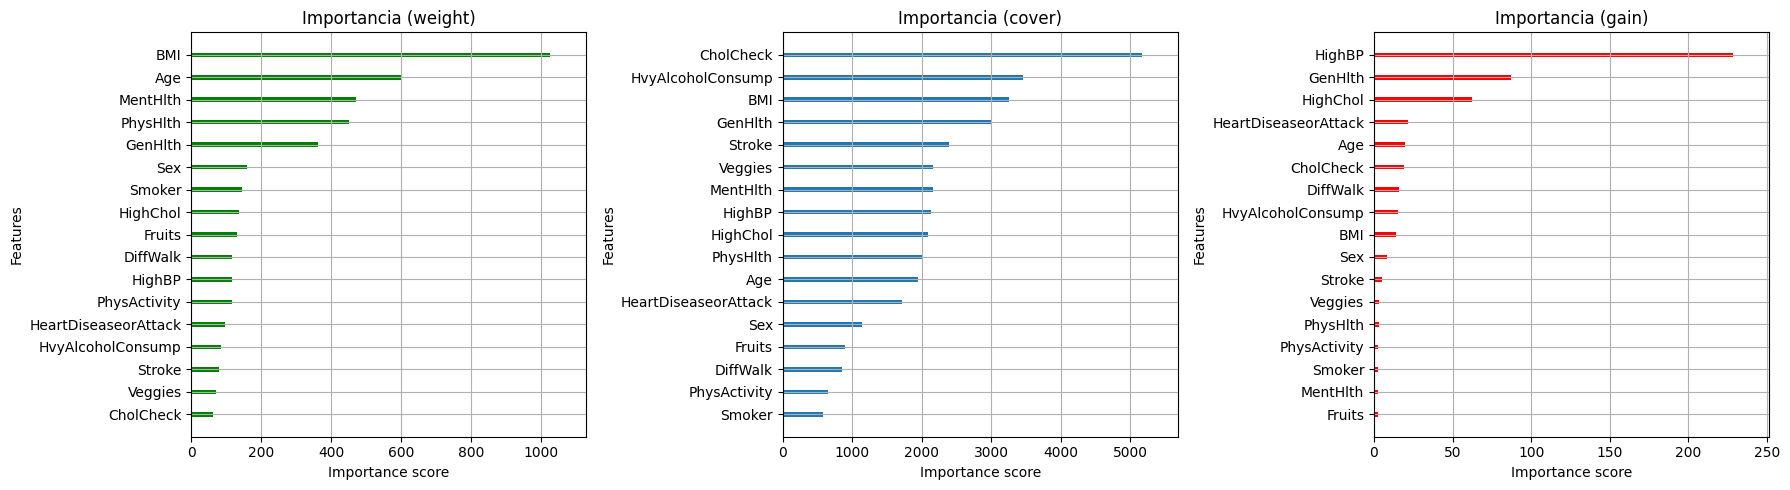

In [9]:
# === Punto 3 — Importancia de las features con XGBoost (weight, cover, gain) ===
# 1) Tomar el modelo entrenado desde el pipeline
xgb_fitted = pipe.named_steps["xgb"]

# 2) Graficar importancias con los tres métodos: weight, cover, gain
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_importance(xgb_fitted, importance_type="weight", ax=axes[0], color= "green" , title="Importancia (weight)", show_values=False)
plot_importance(xgb_fitted, importance_type="cover",  ax=axes[1], title="Importancia (cover)",  show_values=False)
plot_importance(xgb_fitted, importance_type="gain",   ax=axes[2], color= "red", title="Importancia (gain)",   show_values=False)

plt.tight_layout()
plt.show()

**¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados.**

Los resultados obtenidos con los distintos métodos de importancia no son exactamente iguales, aunque sí muestran cierta coherencia general. En los tres gráficos se repiten varias variables relevantes, como `BMI`, `Age`, `PhysHlth`, `MentlHlth`, `HighBP` y `GenHlth`, pero en diferente orden y con distinta magnitud. Esto ocurre porque cada tipo de importancia mide un aspecto diferente del uso de las variables dentro de los árboles. Weight contabiliza cuántas veces una variable se usa para dividir, cover mide cuántas muestras cubren esos nodos y gain evalúa la mejora promedio en la pérdida que genera cada split. Por lo tanto, las diferencias reflejan que algunas variables pueden ser utilizadas con frecuencia pero aportar poca ganancia informativa, mientras que otras, aunque se usen menos, generan divisiones mucho más efectivas. 

**¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?**

Las importancias obtenidas permiten una primera aproximación a la interpretabilidad del modelo, mostrando qué variables influyen más en las decisiones globales del clasificador. Sin embargo, este enfoque tiene limitaciones importantes. En primer lugar, no explica cómo una variable específica afecta la predicción en cada caso individual, ni muestra la dirección del efecto. Además, las métricas de importancia pueden ser sensibles a la escala de las variables y al grado de correlación entre ellas. Cuando dos variables están fuertemente relacionadas, el modelo puede repartir su importancia de forma arbitraria.

## 4. Métodos Agnósticos Globales (10 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Tareas:
1. Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. `Nota:`Tenga cuidado con el orden de las columnas de este método. `Hint:` Puede obtener los features del clasificador con su respectivo orden mediante el método `.get_booster().feature_names` (2 puntos)
2. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala esta?). (2 puntos)
3. Visualice los resultados de este método en un gráfico. (2 puntos)
4. Además, responda las siguientes preguntas:
  - ¿Cómo mide la importancia de las features su propuesta? (1 punto)
  - ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿tienen sentido? (1 punto)
  - ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior? (1 punto)
  - Nombre y explique 3 ventajas y 3 desventajas del método implementado. (1 punto)

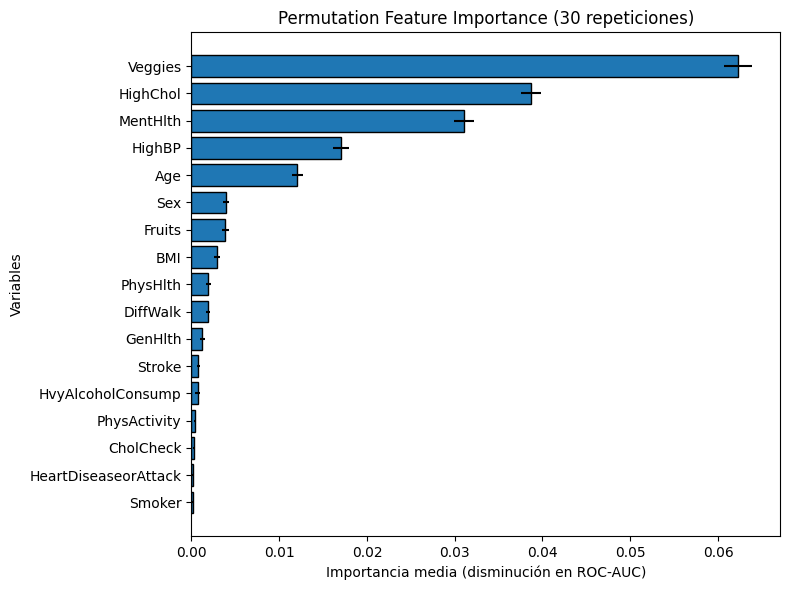

,feature,importance_mean,importance_std
11,Veggies,0.062277,0.001590
4,HighChol,0.038704,0.001122
0,MentHlth,0.031078,0.001115
16,HighBP,0.017003,0.000903
2,Age,0.012071,0.000648
3,Sex,0.003955,0.000345
10,Fruits,0.003884,0.000416
6,BMI,0.002933,0.000347
1,PhysHlth,0.001933,0.000295
14,DiffWalk,0.001863,0.000246


In [ ]:
# === Punto 4 — Métodos Agnósticos Globales (Permutation Feature Importance) ===

# 1) Calcular importancias por permutación
r = permutation_importance(
    pipe, X_test, y_test,
    n_repeats=30,
    random_state=42,
    scoring="roc_auc"
)

# 2) Crear DataFrame ordenado
importances_df = (
    pd.DataFrame({
        "feature": xgb_fitted.get_booster().feature_names,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

# 3) Visualizar resultados
plt.figure(figsize=(8,6))

plt.barh(
    importances_df["feature"],
    importances_df["importance_mean"],
    xerr=importances_df["importance_std"],
    edgecolor="black"
)

plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance (30 repeticiones)")
plt.xlabel("Importancia media (disminución en ROC-AUC)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

# Mostrar tabla resumida para ver la varianza
display(importances_df)


**¿Cómo mide la importancia de las features su propuesta?**

El método de permutación mide la importancia de una característica evaluando cuánto disminuye el rendimiento del modelo cuando se altera aleatoriamente esa variable, manteniendo el resto de los datos fijos. Si al permutar una feature el modelo pierde precisión (por ejemplo, baja el ROC-AUC), significa que dicha variable era relevante para las predicciones. En cambio, si el rendimiento casi no cambia, la feature tenía poca o nula contribución. En este caso, la métrica utilizada fue el área bajo la curva ROC, por lo que las importancias reflejan cuánto aporta cada variable al poder discriminativo del modelo.

**¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿tienen sentido?**

Las variables con mayor impacto según el método de permutación fueron `Veggies`, `HighCol`, `MentlHlth`, `HighBp` y `Age`. Estas variables tienen un fuerte sentido clínico, ya que todas ellas se relacionan directamente con el riesgo de diabetes.
- Veggies: Consumo de vegetales es indicador de calidad de dieta, afectando el riesgo de diabetes
- HighCol: Colesterol alto tiene relación medicinal con diabetes.
- MentHlth: salud mental (estrés, depresión, etc) afecta control glicemico, afectando el riesgo de diabetes y viceversa (diabetes también afecta salud menta)
- HighBP: Hipertensión y diabetes son comorbilidades frecuentes.
- Age: Tiene sentido que la presencia de diabetes aumente con la edad.

**¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?**

Las features seleccionadas cambian totalmente respecto a lo observado en el método anterior. 
En comparación con el método de importancia basado en árboles (XGBoost), los resultados del método de permutación son más equilibrados y estables, reflejando mejor el impacto real de cada variable en la predicción. Mientras que el XGBoost tiende a sobrevalorar las variables con más divisiones o con alta cardinalidad, la permutación mide directamente el efecto sobre el desempeño global del modelo.

**Nombre y explique 3 ventajas y 3 desventajas del método implementado.**

Entre las principales ventajas del método de permutación se encuentran:

- Es un modelo agnóstico, es decir, puede aplicarse a cualquier tipo de modelo sin importar su estructura interna

- Proporciona una medida directa del impacto de cada variable sobre el desempeño, lo que facilita la interpretación global

- Permite cuantificar la estabilidad de las importancias mediante repeticiones y desviación estándar.

Sin embargo, también presenta desventajas importantes:

- Es computacionalmente costoso, ya que requiere múltiples evaluaciones del modelo
- Puede ser inestable con variables correlacionadas, ya que la permutación rompe las dependencias entre ellas y distorsiona su contribución real
- Sus resultados dependen del conjunto de test, por lo que distintos splits de datos pueden producir variaciones leves en las importancias.

## 5. Métodos Agnósticos Locales (20 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/10-24-2024/oMCrLI.gif" width="400">
</p>

### 5.1 Calculando Shap Values (4 puntos)

Tareas:
1. Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. (2 puntos)
2. ¿Qué representa cada número en su resultado? (1 punto)
3. ¿Es posible atribuir un significado a la positividad/negatividad de cada valor? (1 punto)

In [11]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [12]:
# Inserte código para calcular shapley values aquí

# 1. CALCULAR SHAP VALUES
# Transformar datos de prueba
X_test_transformed = pipe.named_steps["prep"].transform(X_test)

# Crear explainer
xgb_model = pipe.named_steps["xgb"]
explainer = shap.TreeExplainer(xgb_model)

# Calcular SHAP values
shap_values = explainer(X_test_transformed)

shap_values.shape

(23564, 17)

**¿Qué representa cada número en su resultado?**

El resultado es un array de tamaño (23564, 17), que representa los 23564 pacientes y 17 features. Cada número SHAP representa la contribución marginal de esa feature a la predicción del paciente, i.e. cuánto se desvía la predicción de ese paciente del promedio debido a esa feature específica.

**¿Es posible atribuir un significado a la positividad/negatividad de cada valor?**

Sí:
- SHAP > 0 (Positivo): La feature "empuja" la predicción hacia diabetes (aumenta riesgo)
- SHAP < 0 (Negativo): La feature "empuja" la predicción HACIA no-diabetes (reduce riesgo)
- SHAP ≈ 0: La feature tiene poco/nulo impacto en la predicción de este paciente


### 5.2 Aporte local (4 puntos)

1. Usando los *shap values* calculados, grafique el **aporte local** de las diferentes variables para las instancias **1**, **9** y **150** (1 punto).

2. Interprete sus resultados y responda:

  - ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? (1 punto)

  - ¿Existe algún patrón común entre las instancias analizadas? (1 punto)

  - ¿Es posible generalizar estas conclusiones a todo el dataset? (1 punto)

Instancia n°:  1
Clase: Diabetes

Waterfall Plot - Contribución de cada feature:


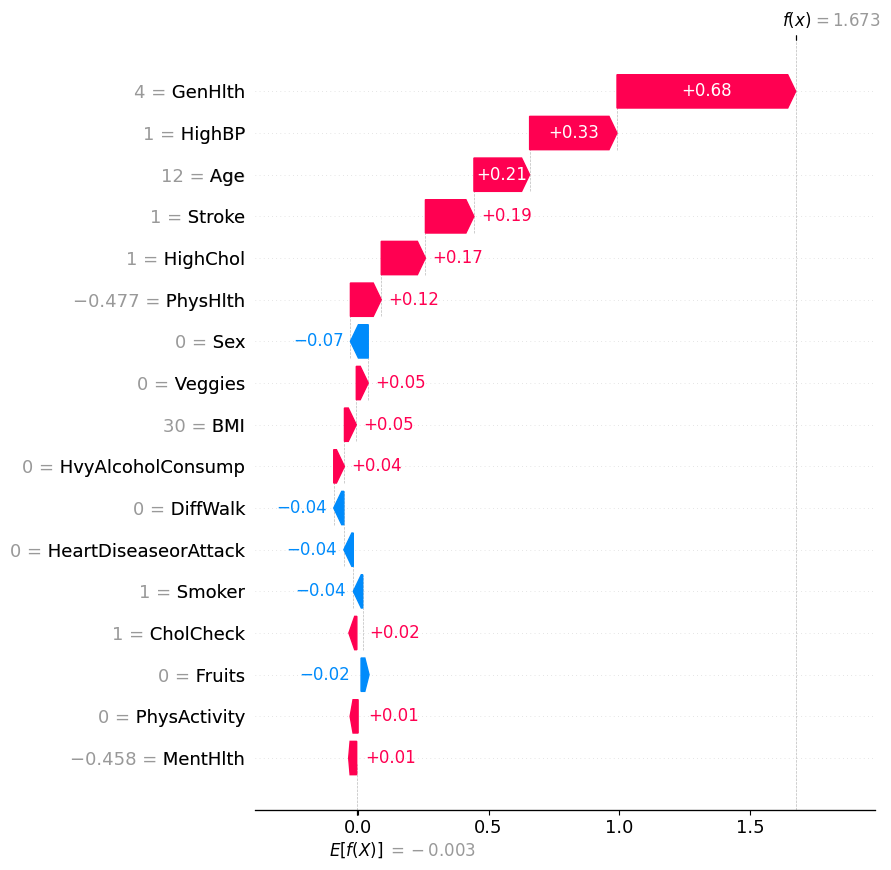

Instancia n°:  9
Clase: No Diabetes

Waterfall Plot - Contribución de cada feature:


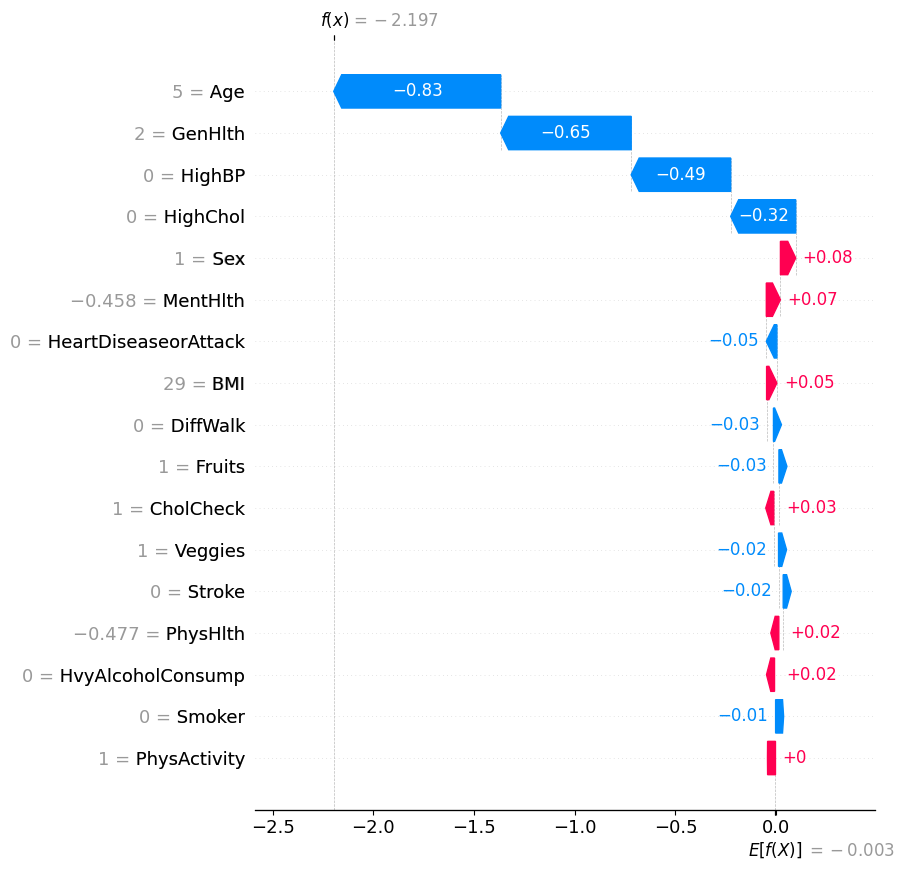

Instancia n°:  150
Clase: Diabetes

Waterfall Plot - Contribución de cada feature:


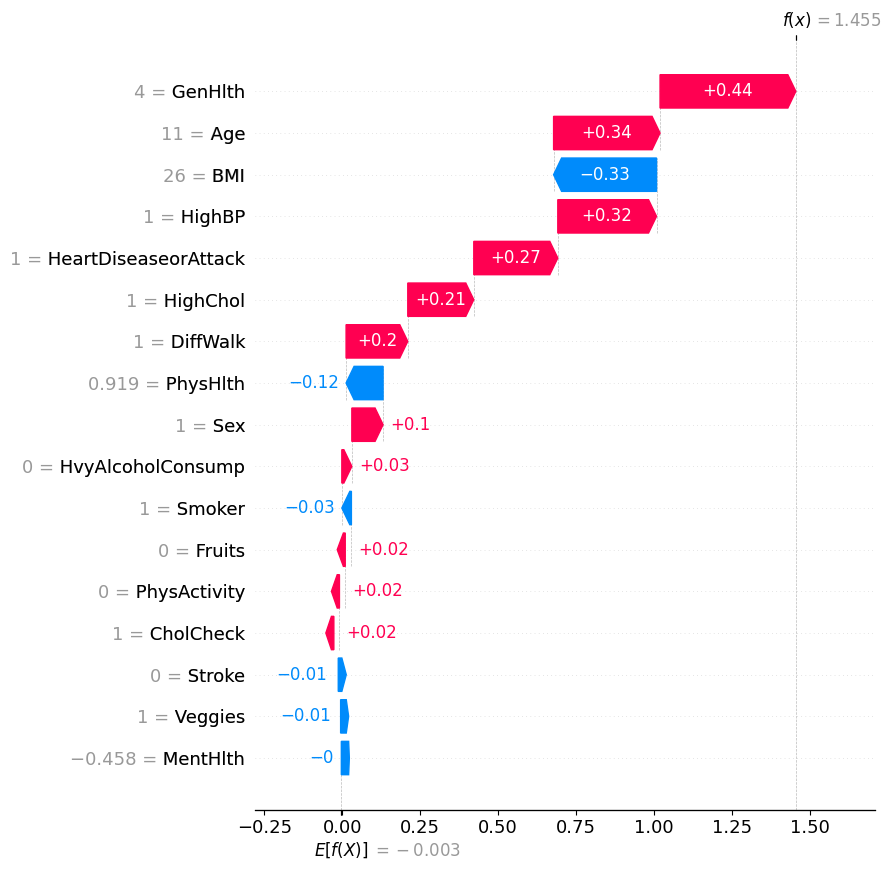

In [13]:
# Inserte código para generar gráficos de aporte local aquí

instancias = [1, 9, 150]

for patient_idx in instancias:
    print("Instancia n°: ", patient_idx)
    print(f"Clase: {'Diabetes' if y_test.iloc[patient_idx] == 1 else 'No Diabetes'}")

    # Waterfall plot: explica la predicción del paciente
    print("\nWaterfall Plot - Contribución de cada feature:")
    shap.plots.waterfall(shap_values[patient_idx], max_display=17)
    plt.show()

**¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?**

Las variables que afectan de manera positiva/negativa a la probabilidad de poseer diabetes son distintas en cada intancia.
- Para los pacientes n°1 y n°150 (tienen diabetes), `GenHlth`, `HighBP` y `Age` tienen el mayor efecto positivo (aumentan la probabilidad de tener diabetes). Para el paciente n°1, ninguna variable tiene un efecto negativo considerable, siendo `Sex` con -0.07 la de mayor efecto. En cambio, para el paciente n°150 `BMI`reduce considerablemente su probabilidad de diabetes.
- Para el paciente 9 (no tiene diabetes), `Age`, `GenHlth`, `HighBP` u  `HighCol` tienen efectos negativos considerables (disminuyen la probabilidad de tener diabetes), mientras que los efectos positivos no son considerables, siendo `Sex` con 0.08 la de mayor efecto.

**¿Existe algún patrón común entre las instancias analizadas?**

El patrón más relevante es que en ambos casos con diabetes (n°1 y n°150), las variables que más aumentaron la probabilidad de tener diabetes fueron las mismas (`GenHlth`, `HighBP` y `Age`). Otro patrón relevante, que tiene bastante sentido, es que los valores SHAP tienden a ser bajos en la dirección "opuesta" a la clase real. Es decir, si la clase real es 1, la mayoría de los SHAP también tienen valores positivos, y viceversa.

**¿Es posible generalizar estas conclusiones a todo el dataset?**

No sería razonable generalizar estas conclusiones a todo el dataset, ya que la cantidad de escenarios observados es muy baja. Además, es probable que el modelo no utilice las mismas features para tomar decisiones en todos los pacientes (por ejemplo, puede ocurrir que alguien en edad de bajo riesgo(feature con alto shap en los casos observados) tenga diabetes, y el modelo lo clasifique como positivo a pesar de esto, debido a los valores de otras features).

### 5.3 Aporte global (4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

SHAP Values - Nivel Global


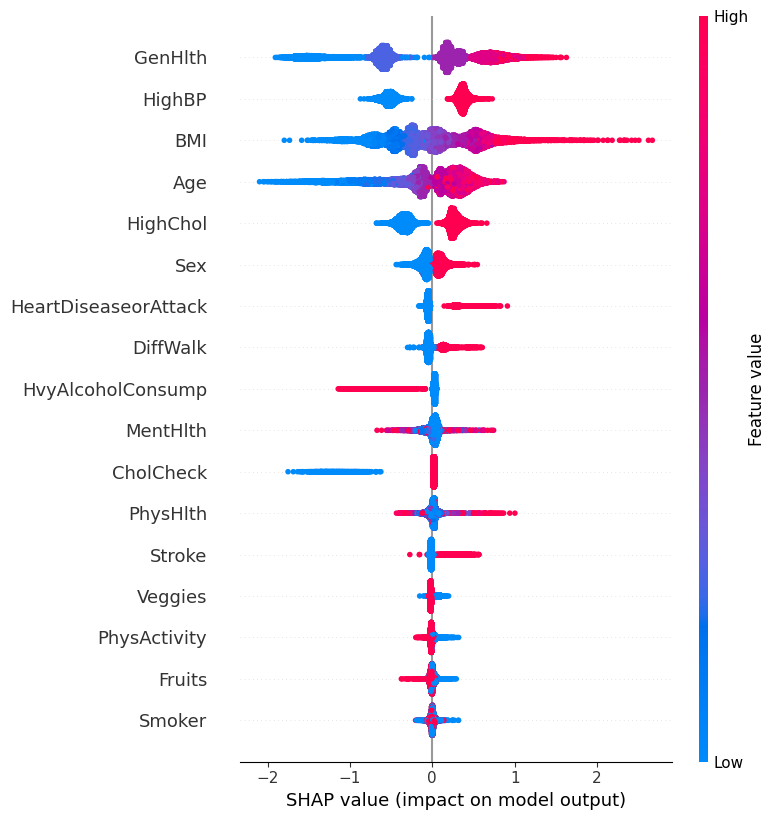

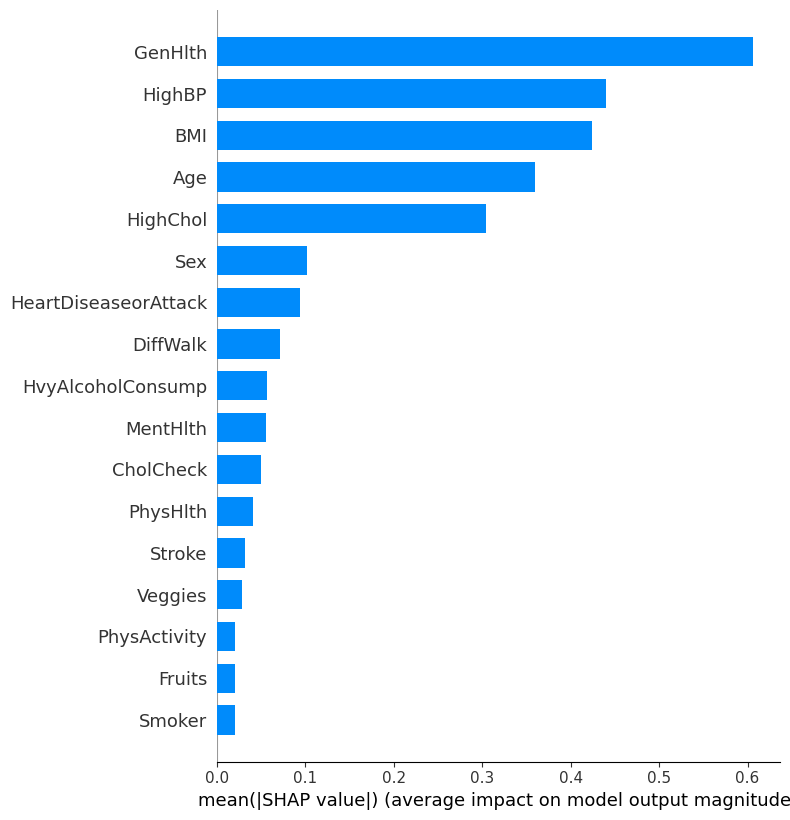

In [14]:
# Inserte código para generar gráficos de aporte global aquí

# 1. Summary Plot (Beeswarm) - Visualización de aportes
print("SHAP Values - Nivel Global")
shap.summary_plot(shap_values, X_test_transformed, max_display=17)

# 2. Bar Plot - Importancia promedio
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar", max_display=17)


El summary Plot (Beeswarm) muestran un patrón muy relevante, donde la división entre valores altos o bajos de cada feature determina si esta tiene un shap positivo o negativo. Algo interesante, es que no todos los valores son intuitivos, ya que vemos por ejemplo que valores altos de `GenHlth` aumentarían el riesgo de diabetes (lo más probable, es que sea un indicador de salur deteriorada, más que uno de salud general), pero también vemos situaciones razonables, donde una edad o BMI mayor también aumentan el riesgo de diabetes.

El barplot muestra que, a nivel global, algunas variables como `GenHlth`, `HighBP`, `BMI`, etc. tienen un mayor efecto global (i.e. generan, en promedio, los mayores "desplazamientos" del resultado).

**¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?**

A nivel local (de instancia), se puede generar conclusiones respecto al efecto de cada feature en la predicción para ese paciencie en particular, mientras que a nivel global se pueden generar conclusiones respecto al efecto promedio de cada feature en las predicciones.
Es decir, a nivel global buscamos patrones generales, y a nivel local patrones individuales, donde, por ejemplo, una feature globalmente importante puede no serlo localmente (para una persona en particular) y viceversa.


### 5.4 Scatter plot (4 puntos)


Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

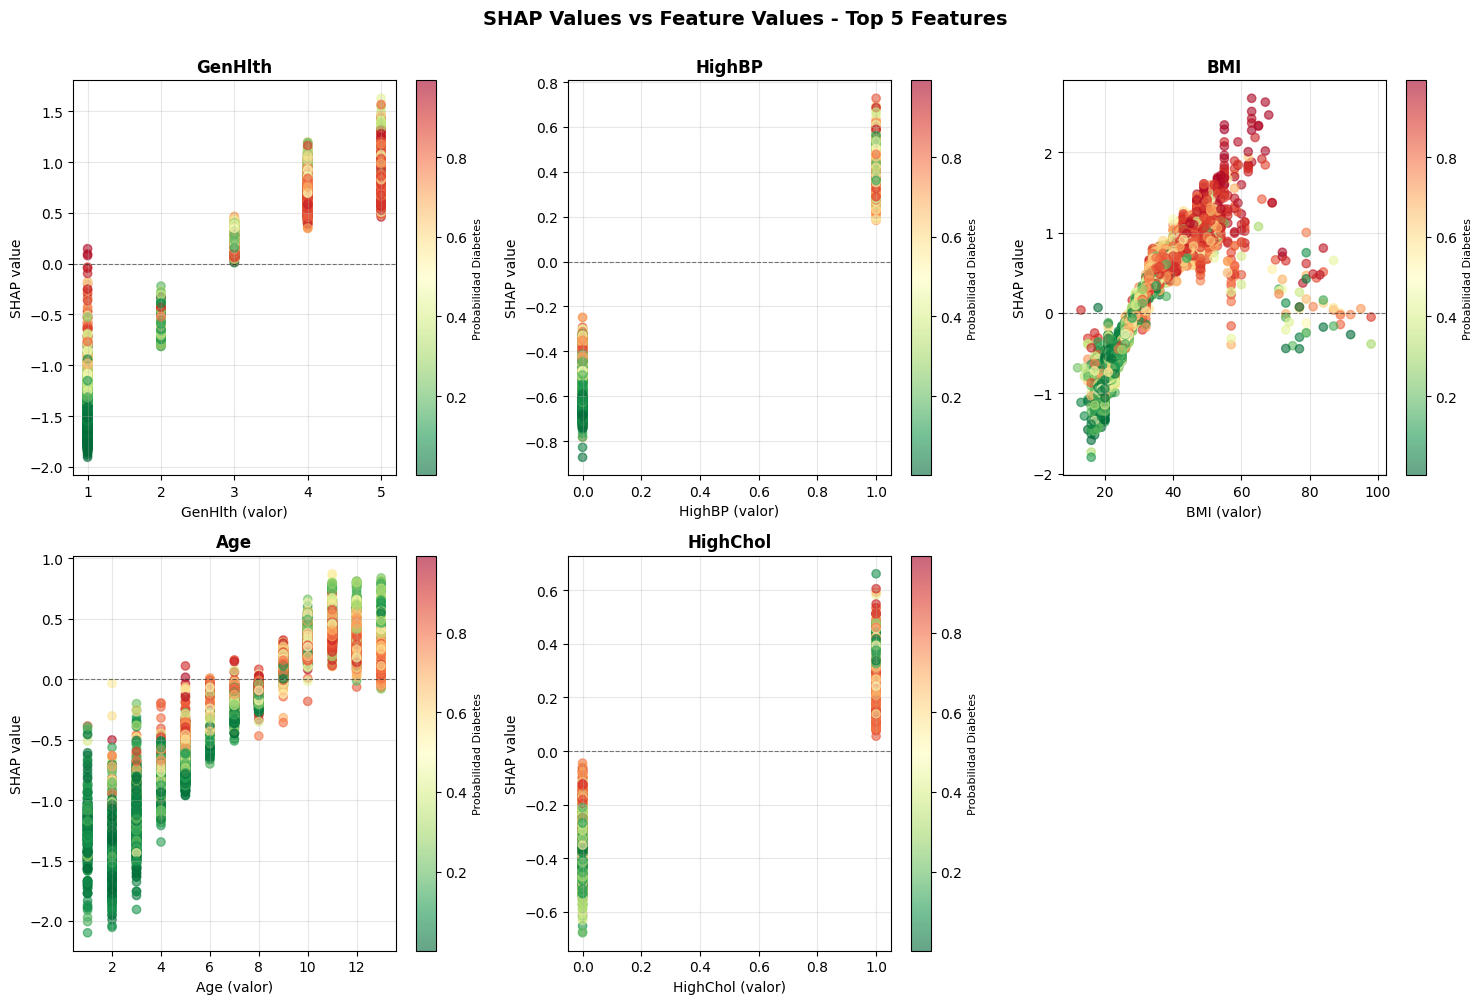

In [15]:
# Inserte código para generar gráficos de feature vs shap value aquí

# 1. Obtener top 5 features más importantes globalmente
feature_names= X_test_transformed.columns.tolist()

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
global_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False)

top_5_features = global_importance.head(5)['feature'].values

# 2. Calcular probabilidades de diabetes para colorear
probabilities = xgb_model.predict_proba(X_test_transformed)[:, 1]

# 3. Crear scatterplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_5_features):
    # Obtener índice de la feature
    feature_idx = list(feature_names).index(feature)
    
    # Valores de la feature y sus SHAP values
    feature_values = X_test_transformed[feature].values
    shap_feature = shap_values.values[:, feature_idx]
    
    # Scatterplot
    scatter = axes[idx].scatter(
        feature_values,
        shap_feature,
        c=probabilities,
        cmap='RdYlGn_r',  # Rojo=alta prob, Verde=baja prob
        alpha=0.6
    )
    
    axes[idx].set_xlabel(f'{feature} (valor)', fontsize=10)
    axes[idx].set_ylabel('SHAP value', fontsize=10)
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[idx].grid(alpha=0.3)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=axes[idx])
    cbar.set_label('Probabilidad Diabetes', fontsize=8)

# Eliminar subplot extra
axes[-1].remove()

plt.suptitle('SHAP Values vs Feature Values - Top 5 Features', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


***¿Qué puede concluir de sus resultados?***

Los scatterplots revelan la presencia de relaciones diversas entre los valores de las features y el indice SHAP. La mayoria presenta una relación relativamente lineal, donde mayor valore de la feature genera un mayor SHAP. `HighBP` y `HighCol`, variables binarias, muestran este patrón de manera muy clara donde el caso positivo (1) tiene shap positivo y el caso negativo (0) tiene shap negativo en todos los casos. El BMI muestra algunos casos que se desvián de la "diagonal" y podrían ser outliers o excepciones. 

En general, el efecto de esto sobre la probabilidad de diabetes no es muy claro, ya que los colores se entremezclan bastante. Nuevamente, `BMI` representa una excepción ya que muestra claramente una relación donde BMI mayor --> SHAP mayor --> mayor probabilidad de diabetes. También se observan un patrón relevante en  `HighBP` y `HighChol`, donde, para valores negativos de SHAP, menores magnitudes aumentan la probabilidad de diabetes. Esto tiene sentido, ya que se realiza un "menor desplazamiento" hacia la clase negativa.

En general, y especialmente debido a la alta mezcla en los colores, se puede concluir que los efectos de las features en el modelo son complejos, y probablemente existen altas interacciones entre estas.

### 5.5 Partial Dependence Plot (4 puntos)

Finalmente, se le pide generar un gráfico del tipo Partial Dependence Plot para las mismas 5 variables con mayor impacto global usando una submuestra de 1000 observaciones. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

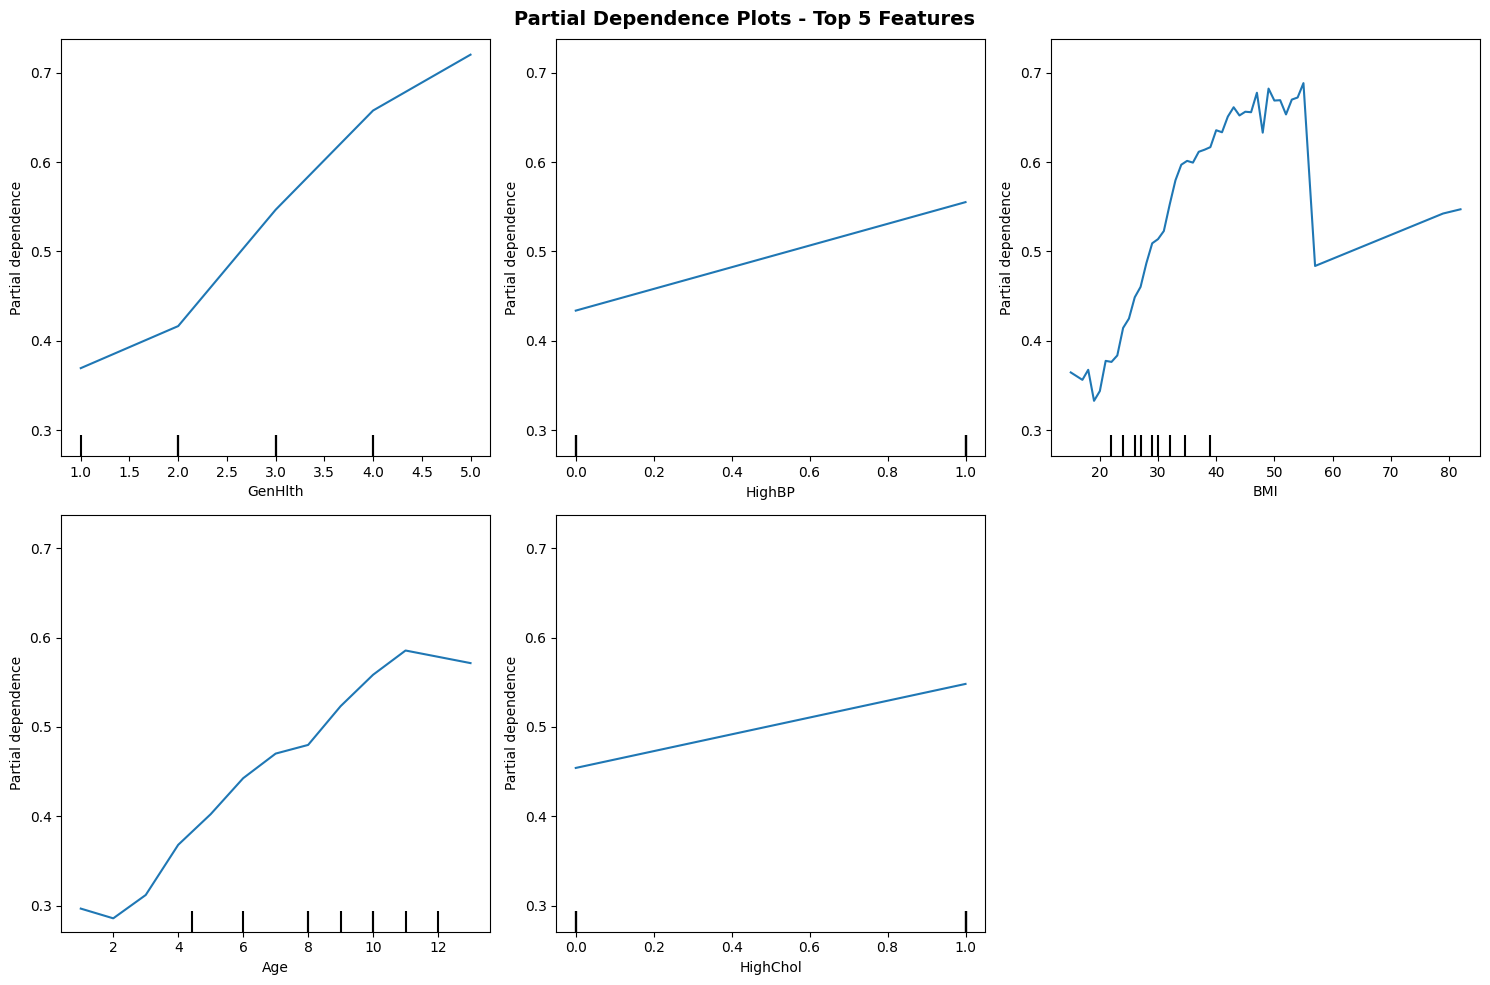

In [16]:
# Inserte código para generar gráficos PDP aquí

# Submuestrear 1000 observaciones
np.random.seed(42)
sample_indices = np.random.choice(len(X_test_transformed), size=1000, replace=False)
X_sample = X_test_transformed.iloc[sample_indices]

# Indices de las top 5 features
feature_indices = [list(feature_names).index(f) for f in top_5_features]

# Plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

display = PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_sample,
    features=feature_indices,
    feature_names=feature_names,
    kind='average',
    ax=axes[:5]
)

# Eliminar subplot extra
axes[-1].remove()

plt.suptitle('Partial Dependence Plots - Top 5 Features', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**¿Qué relación existe entre la salida promedio del modelo y cada feature analizada?**

El PDP muestra la relación promedio entre una feature y la predicción, promediando el efecto de todas las demás features. 
- Eje X: Valores de la feature
- Eje Y: Predicción promedio del modelo

`GenHlth`, `HighBP` y `HighChol` muestran una relación ~lineal creciente, que indica que a mayor valor de la feature, mayor probabilidad de diabetes.
`Age` y `BMI` muestran curvas donde la relación es creciente en algunos tramos y decreciente en otros. Es decir, que el efecto de un mayor valor de la feature (mayor o menor probabilidad de diabetes al aumentar dicha feature) depende del tramo.

**¿Son estas conclusiones generalizables para todo el conjunto de datos?**
Estas conclusiones pueden ser consideradas a nivel global, dado que 1000 es una muestra de tamaño considerable. Sin embargo, hay que interpretar los resultados con cuidado, dado que el promedio puede no ser representativo si hay interacciones entre variables.

## 6. Sistema de Reglas! (10 punto)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo.
En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

`Hint:` Como debe entregar las columnas que entran al clasificador entrenado de su pipeline, le será útil extraer el paso de preprocesamiento y generar dataframes preprocesados para el conjunto `train` y `test`.

In [17]:
# Inserte su código para generar sistema de reglas aquí

# Generar df preprocesados
preprocessor = pipe.named_steps["prep"]
xgb_model = pipe.named_steps["xgb"]
features = xgb_model.get_booster().feature_names

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Función para predicción
predict_fn = lambda x: xgb_model.predict(x)

explainer = AnchorTabular(predict_fn, features, seed=42)
explainer.fit(X_train_transformed.values)

# Población total
n_test = len(X_test)

idx = 1000
# explicar predicción idx 1000
print(f"=== predicción {idx} ===")
x = X_test_transformed.values[idx].reshape(1, -1)
result = explainer.explain(x)

coverage = result.data['coverage']
print('Anclas =', result.data['anchor'])
print(f"Las reglas aplican al {coverage*100:.2f}% de la población")
print(f'En el conjunto de test, esto equivale a: {int(n_test * coverage)} personas')
print(f'Precisión: {result.precision:.4f}', '\n')

idx = 3001
# explicar predicción idx 3001
print(f"=== predicción {idx} ===")
x = X_test_transformed.values[idx].reshape(1, -1)
result = explainer.explain(x)

coverage = result.data['coverage']
print('Anclas =', result.data['anchor'])
print(f"Las reglas aplican al {coverage*100:.2f}% de la población")
print(f'En el conjunto de test, esto equivale a: {int(n_test * coverage)} personas')
print(f'Precisión: {result.precision:.4f}', '\n')

idx = 5751
# explicar predicción idx 5751
print(f"=== predicción {idx} ===")
x = X_test_transformed.values[idx].reshape(1, -1)
result = explainer.explain(x)

coverage = result.data['coverage']
print('Anclas =', result.data['anchor'])
print(f"Las reglas aplican al {coverage*100:.2f}% de la población")
print(f'En el conjunto de test, esto equivale a: {int(n_test * coverage)} personas')
print(f'Precisión: {result.precision:.4f}', '\n')

=== predicción 1000 ===
Anclas = ['GenHlth > 2.00', 'DiffWalk > 0.00', 'Age > 9.00']
Las reglas aplican al 11.25% de la población
En el conjunto de test, esto equivale a: 2650 personas
Precisión: 0.9560 

=== predicción 3001 ===
Anclas = ['GenHlth > 2.00', 'HighBP > 0.00', 'Age > 9.00', 'BMI > 25.00']
Las reglas aplican al 17.45% de la población
En el conjunto de test, esto equivale a: 4111 personas
Precisión: 0.9823 

=== predicción 5751 ===
Anclas = ['GenHlth > 3.00', 'HeartDiseaseorAttack > 0.00']
Las reglas aplican al 8.26% de la población
En el conjunto de test, esto equivale a: 1946 personas
Precisión: 1.0000 



Las reglas para las predicicones nº1000, nº3001 y nº5751 aplican a un 11.25%, 17.45% y 8.26% de la población estudiada, respectivamente. En el conjunto de test, esto equivale a 2650, 4111 y 1946 personas, respectivamente. 
En general, para ser reglas planteadas para una única observación, aplican a una cantidad considerable de personas.

Las precisiones respectivas son de 0.9560, 0.9823 y 1.0000. La interpretación de estos valores, es que una alta proporción de las instancias que cumplen las mismas reglas, son clasificadas de la misma manera que la instancia que se está explicando.

**¿Tienen sentido sus reglas propuestas para las observaciones?**

Las tres las reglas imponen un piso sobre `GenHlth`, dos de ellas sobre `Age` y una sobre `HighBP` y `BMI`. Estas son features que ya se había identificado anteriormente como importantes, por lo que tiene mucho sentido que el algoritmo haya impuesto reglas sobre ellas. 
Por otra parte, para la predicción nº1000 también se impone una regla sobre `DiffWalk`, mientras que para la nº5751 sobre `HeartDiseaseorAttack`, features que no habían destacado en los análisis anteriores. Se puede inferir que esta es una regla más local, lo que se corrobora al observar que los sets respectivos de reglas aplican a una menor cantidad de la población, comparado con el set derivado de la observacion nº3001.


# Retrospectiva... (10 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

**Comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes**

Cada método empleado ofrece *insights* complementarios respecto a la tarea de clasificación de diabetes. En particular, las mejores conclusiones se pueden obtener a través del complemento de distintos mñetodos, siendo SHAP y el sistema de reglas dos de las herramientas más efectivas.

El método inicial (importancia XGBoost), si bien es informativo, obtuvo resultados inconsistentes, resaltando distintas features relevantes según la métrica usada.
El método de permutación mejora este aspecto al permitir promediar diversas instancias, obteniendo resultados mucho más significativos, aunque sin mucho detalle del por qué se escogió esas features.
Luego, métodos como partial dependence plots y scatter plots, si bien no sirven para identificar las features relevantes, entregan un mayor nivel de detalle sobre los efectos de cada feature en la predicción. Sin embargo, su interpretación se vuelve desafiante con interacciones complejas entre features, como se observó en este caso.

El método **SHAP** engloba los beneficios de los métodos anteriores, destacando como el más completo. Permite, tanto a escala local como global, identificar las features más relevantes y además cuantificar su efecto directo sobre las predicciones. Especialmente, al usar Beeswarm y Waterfall plots, se puede visualizar este efecto de manera muy clara e intuitiva. 
Como complemento, el **sistema de reglas**, si bien solo aplica al contexto local, ofrece interpretaciones aúnn más directas sobre aquellos factores que determinan si alguien tiene diabetes o no. Este no solo indica las features que llevaron al modelo a tomar la decisión, sino que además el criterio de corte sobre el valor de la feature utilizado para tomar esta decisión.

En conclusión, SHAP ofrece el entendimiento más profundo del comportamiento del modelo, mientras que el sistema de reglas ofrece la explicación más clara para el usuario final.

**Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?**

El objetivo particular del doctor Simi es obtener un modelo capaz de predecir/clasificar diabetes, con un especial enfoque en la **interpretabilidad** de lo que hace el modelo.
En este sentido, **tanto métodos agnósticos locales como globales son fundamentales**, pues ofrecen interpretaciones sobre aspectos muy distintos del modelado:

> Los métodos globales permiten entender qué features son, en general, las más decisivas en la población estudiada, además de su efecto sobre el comportamiento general del modelo. Entrega *insights* generalizables, que probablemente aplican a una buena proporción de la población. Es decir, permiten derivar recomendaciones generales para identificar rápidamente casos de riesgo, por ejemplo, en campañas preventivas. También permiten corroborar que el modelo se esta basando en factores medicamente reconocidos para realizar su predicción. 

> Los métodos locales son fundamentales para la interpretabilidad caso a caso, especialmente si el diagnóstico de un paciente no se basa en los motivos más comunes globalmente. Estos son especialmente importantes si se quiere entender, para un paciente en particular, cuáles son sus factores de riesgo específicos, con tal de ofrecer un tratamiento apropiado.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>